In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import date
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA

/Users/KenLu/anaconda/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
SEED = 1990
N_CLUSTERS = 8
WINDOW_SIZE = 100
VAR_PERCENTILE_LEVEL = 5
METRIC = "dtw"
FONT = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }

In [3]:
connection = pg.connect(database="postgres", user="postgres", password="Crypto01", host="localhost", port=5430)
cur = connection.cursor()

In [4]:
cur.execute("SELECT * FROM input.stock_daily_changes ORDER BY date DESC")
data = sorted(cur.fetchall(), key=lambda row: row[0], reverse=False)
daily_changes = pd.DataFrame(data=data, columns=[desc[0] for desc in cur.description], index=[row[0] for row in data], dtype="float64")
daily_changes = daily_changes.drop(["date"], axis=1)
daily_changes = daily_changes[daily_changes.index <= date(2018, 7, 31)]
daily_changes = daily_changes[daily_changes.index >= date(2016, 1, 1)]
daily_changes = daily_changes - 1
transpose_df = daily_changes.transpose()

<Figure size 432x288 with 0 Axes>

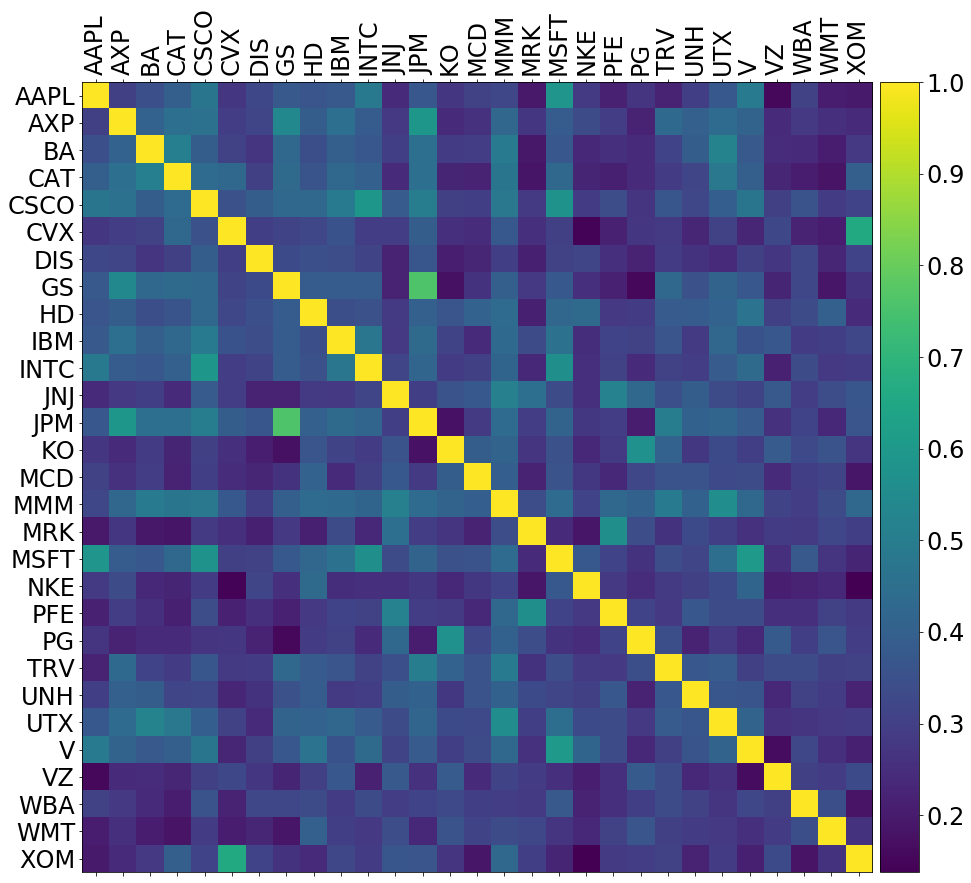

In [5]:
corr_mat = daily_changes.corr()
cryptos = np.array(corr_mat.columns)
plt.clf()
plt.rcParams['figure.figsize'] = [20, 15]
plt.matshow(corr_mat)
plt.xticks(range(len(cryptos)), cryptos, rotation="vertical", fontsize=24)
plt.yticks(range(len(cryptos)), cryptos, fontsize=24)
# plt.xlabel("Correlation", fontdict=FONT)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

plt.colorbar(cax=cax)
plt.tick_params(labelsize=24)
plt.show()

In [6]:
transpose_array = np.array(transpose_df)

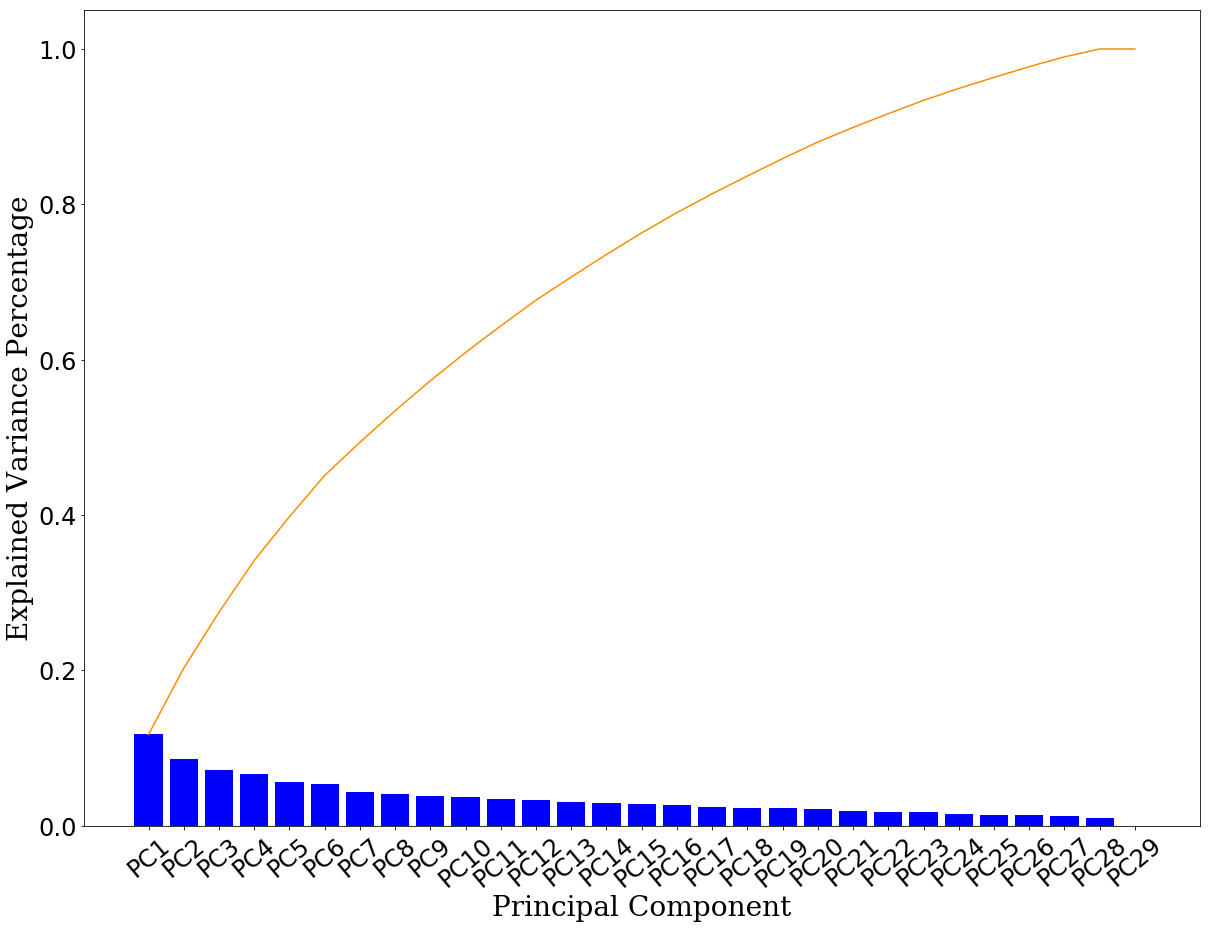

In [32]:
pca_plot = PCA(n_components=29)
pca_plot.fit(transpose_array)

cumsum_variance_ratio = np.cumsum(pca_plot.explained_variance_ratio_)
pc_names = ["PC" + str(i) for i in range(1, 30)]

plt.clf()
plt.plot(cumsum_variance_ratio, color="darkorange")
plt.bar(range(0, 29), pca_plot.explained_variance_ratio_, color="blue")
plt.yticks(fontsize=24)
plt.xticks(range(0, 29), pc_names, rotation=40, fontsize=24)
plt.xlabel("Principal Component", fontdict=FONT, fontsize=28)
plt.ylabel("Explained Variance Percentage", fontdict=FONT, fontsize=28)
plt.show()

In [8]:
pca = PCA(n_components=27)
pca_array = pca.fit_transform(transpose_array)
dba_km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, max_iter=100, metric=METRIC, verbose=True, max_iter_barycenter=10, random_state=SEED)
pred_clusters = dba_km.fit_predict(pca_array)

0.014 --> 0.010 --> 0.010 --> 


In [9]:
print("Percentage of interpretation:", sum(pca.explained_variance_ratio_))

Percentage of interpretation: 0.989874464366


In [10]:
for cluster in set(pred_clusters):
    print("Cluster", cluster + 1, ":", cryptos[np.where(pred_clusters == cluster)])

Cluster 1 : ['JNJ' 'KO' 'MCD' 'MRK' 'PFE' 'PG' 'VZ' 'WMT']
Cluster 2 : ['GS' 'JPM']
Cluster 3 : ['AXP' 'BA' 'INTC' 'NKE' 'WBA']
Cluster 4 : ['AAPL' 'CSCO' 'MSFT' 'V']
Cluster 5 : ['CAT']
Cluster 6 : ['CVX' 'UNH' 'XOM']
Cluster 7 : ['DIS' 'HD' 'IBM' 'TRV' 'UTX']
Cluster 8 : ['MMM']


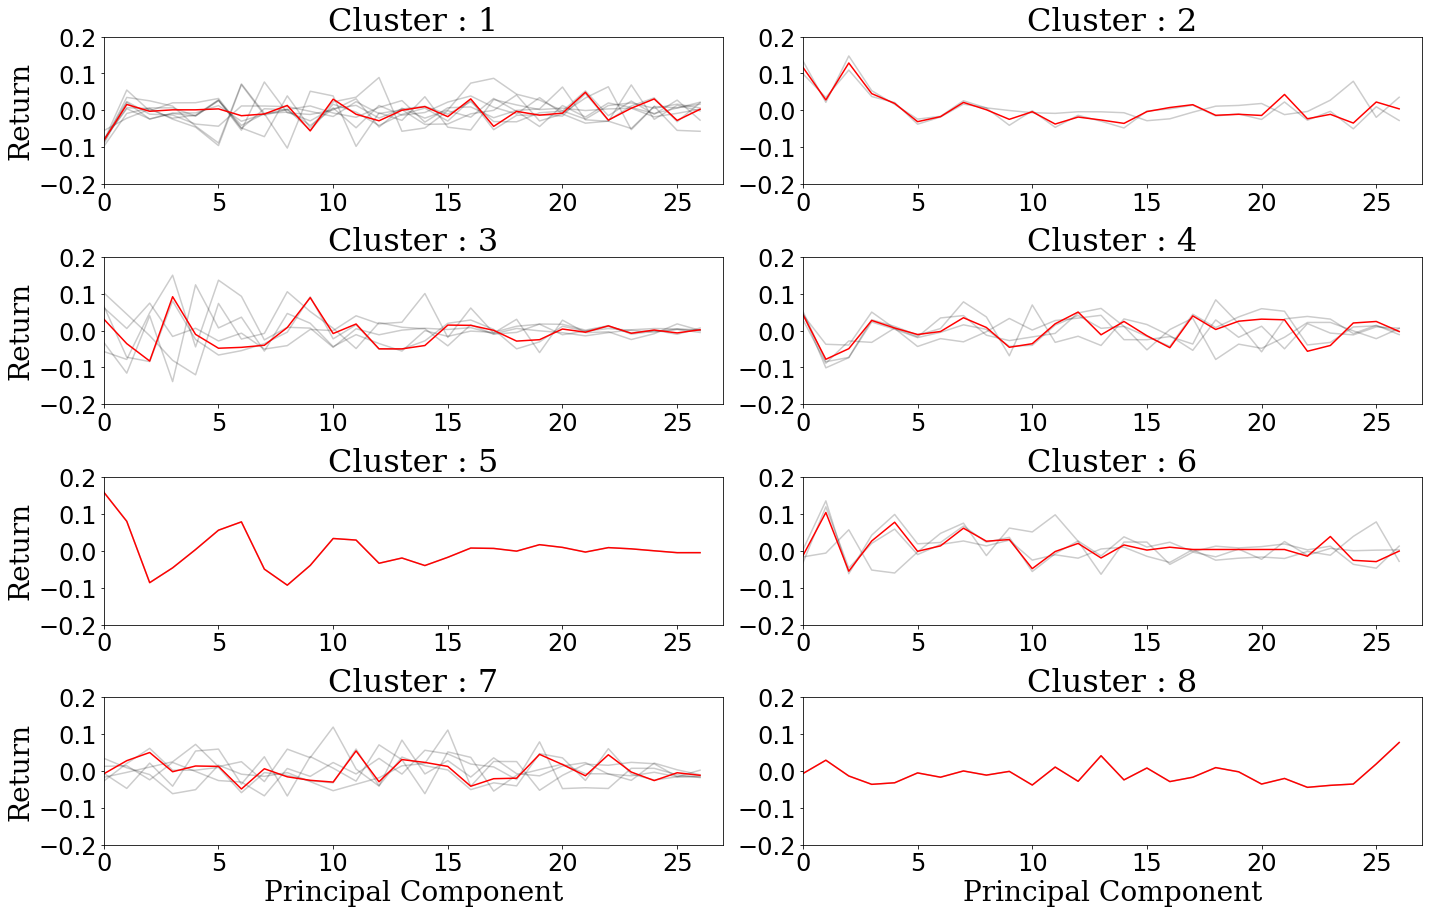

In [11]:
# Plot
plt.clf()
plt.rcParams['figure.figsize'] = [20, 15]
for yi in set(pred_clusters):
    plt.subplot(N_CLUSTERS/2 + 1, 2, yi + 1)
    for xx in pca_array[pred_clusters == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, pca_array.shape[1])
    plt.ylim(-0.2, 0.2)
    title = "Cluster : " + str(yi + 1)
    plt.title(title, fontdict=FONT, fontsize=32)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    if yi % 2 == 0 :
        plt.ylabel("Return", rotation="vertical", fontdict=FONT, fontsize=28)
    if yi == 6 or yi == 7:
        plt.xlabel("Principal Component", fontdict=FONT, fontsize=28)

plt.tight_layout()
plt.show()

In [12]:
vars_arr_before = []
vars_arr_after = []

for i in range(0, transpose_array.shape[1] - WINDOW_SIZE):
    vars_arr_before.append([np.percentile(row, VAR_PERCENTILE_LEVEL) for row in transpose_array[:, i: i + WINDOW_SIZE]])
    cluster_vars = []
    for j in set(pred_clusters):
        cluster_vars.append([np.percentile(np.hstack(row), VAR_PERCENTILE_LEVEL) for row in transpose_array[pred_clusters == j, i: i + WINDOW_SIZE]])
    cluster_vars = np.hstack(cluster_vars)
    vars_arr_after.append(cluster_vars)

vars_arr_before = np.array(vars_arr_before).transpose()
vars_arr_after = np.array(vars_arr_after).transpose()

In [13]:
vars_arr_after.shape

(29, 549)

In [14]:
vars_arr_before

array([[-0.02591178, -0.02591178, -0.02568039, ..., -0.01667898,
        -0.02049236, -0.02049236],
       [-0.01537284, -0.01537284, -0.01537284, ..., -0.01493621,
        -0.01493621, -0.01514354],
       [-0.02218983, -0.02218983, -0.02218983, ..., -0.02868202,
        -0.02868202, -0.02944501],
       ..., 
       [-0.02120504, -0.02120504, -0.02067709, ..., -0.02412447,
        -0.02412447, -0.02412447],
       [-0.01607734, -0.01607734, -0.01607734, ..., -0.01938727,
        -0.01938727, -0.01938727],
       [-0.01769963, -0.01769963, -0.01769963, ..., -0.01298097,
        -0.01298097, -0.01298097]])

In [15]:
vars_arr_before.shape

(29, 549)

In [24]:
count = 0
for i in range(0, 28):
    count += np.sum(transpose_array[i, WINDOW_SIZE:] < vars_arr_before[i, :]) > 29 or np.sum(transpose_array[i, WINDOW_SIZE:] < vars_arr_before[i, :]) < 25
p_value_2side_before = count/29

In [17]:
count = 0
for i in range(0, 28):
    count += np.sum(transpose_array[i, WINDOW_SIZE:] < vars_arr_after[i, :]) > 29 or np.sum(transpose_array[i, WINDOW_SIZE:] < vars_arr_after[i, :]) < 25
p_value_2side_after = count/29

In [ ]:
accuracies_before = np.array([np.sum(transpose_array[i, WINDOW_SIZE:] > vars_arr_before[i, :]) / vars_arr_before.shape[1] for i in range(0, vars_arr_before.shape[0])])
accuracies_after = np.array([np.sum(transpose_array[i, WINDOW_SIZE:] > vars_arr_after[i, :]) / vars_arr_after.shape[1] for i in range(0, vars_arr_after.shape[0])])

In [ ]:
accuracies_before

In [ ]:
accuracies_after